## ESG & Impact Investing -- Assignment 1: Vail Resorts Quantitative Analysis ##

In [13]:
# Set-up steps
import pandas as pd
import numpy as np
import warnings
import textwrap
from pandas.errors import SettingWithCopyWarning 

warnings.filterwarnings("ignore", category=SettingWithCopyWarning)
esg_df = pd.read_csv("Assignment 1/Assignment_1.csv")

In [14]:
# Organizing our data to manageable levels (a)
target_company = 'J M Smucker Co'
target_attributes = {'Consumer Non-Cyclicals', 'Food & Beverages', 'Food & Tobacco'}

select_peers_df = esg_df[(esg_df['TRBC Economic Sector Name'].isin(target_attributes)) &
                       (esg_df['TRBC Business Sector Name'].isin(target_attributes)) &
                       (esg_df['TRBC Industry Group Name'].isin(target_attributes))
                ]

# checking for how complete the data is 
select_peers_df.loc[:, 'Percent_Missing'] = select_peers_df.isnull().sum(axis=1) / len(select_peers_df.columns) * 100

# once we know how much of the data is missing, we will pull the companies with the least amount of missing data
select_peers_df_sorted = select_peers_df.sort_values(by='Percent_Missing')
top10_selectedcomp = select_peers_df_sorted.head(11)

# Confirm if the target is in this top 10 list
target_company_data = select_peers_df[select_peers_df['Company Common Name'] == target_company]
if target_company not in top10_selectedcomp['Company Common Name'].values:
    # If not, drop the last row of the top 10 and add the target company
    top10_selectedcomp = pd.concat([top10_selectedcomp.iloc[:-1], target_company_data])
elif target_company in top10_selectedcomp['Company Common Name'].values:
    print(f"yes, {target_company} is already in the top 10 list.")


# outputting our results
max_line_length = 80
company_names = ', '.join(top10_selectedcomp['Company Common Name'].tolist())
wrapped_names = textwrap.fill(company_names, width=max_line_length)

print(f"There are {len(select_peers_df)} possible comparable companies to explore.")
print(f"Our 10 companies of study will be: \n{wrapped_names}")


yes, J M Smucker Co is already in the top 10 list.
There are 50 possible comparable companies to explore.
Our 10 companies of study will be: 
Altria Group Inc, Campbell Soup Co, Hershey Co, Calavo Growers Inc, Conagra
Brands Inc, Mondelez International Inc, J M Smucker Co, Hormel Foods Corp,
General Mills Inc, Archer-Daniels-Midland Co, Ingredion Inc


The rationale for the proces above is to isolate the companies that are comparable to JM Smucker in terms of their TRBC designations. This filtration process produced 50 companies, from which I sorted to find the companies with the most available ESG data and selected the top 10 to allow for easier comparison in the rest of this analysis.

# Identifying Select Key ESG Metrics (b)

1) Scope 1 Emissions Cross-Comparison (E)

2) Proportion of Energy from Responsible Sources (E)

3) Company Diversity in Staff and Leadership Index (S)

4) Employee Quality Experience Index (S)

5) Total Debt to Total Equity (G)

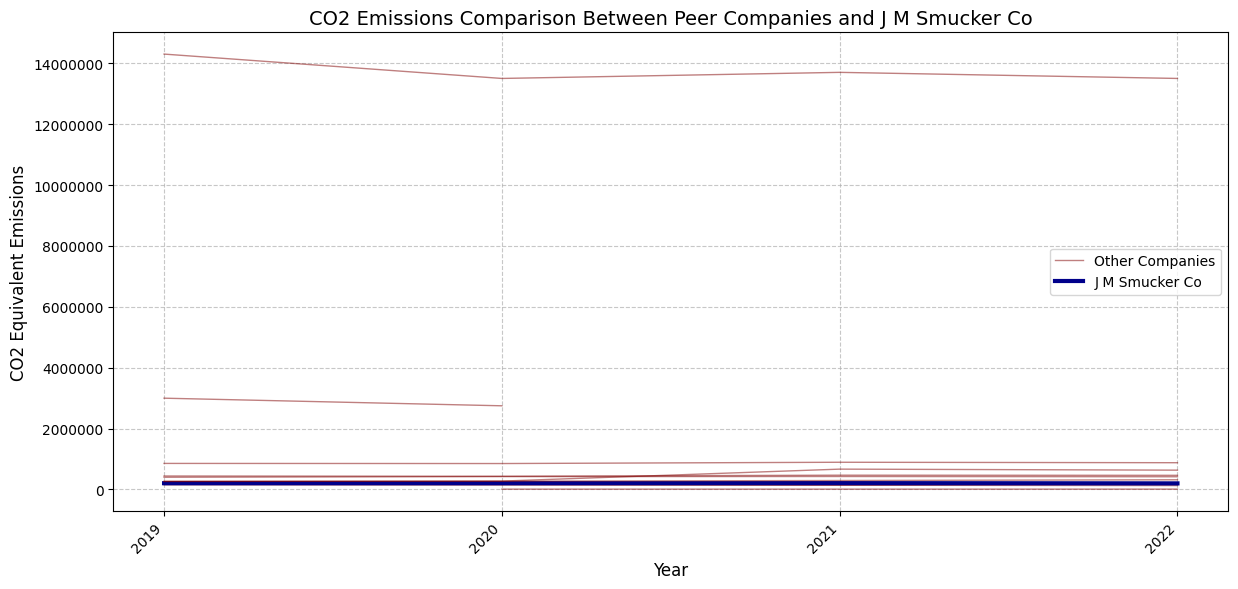

In [15]:
# Data analysis on key ESG Metrics (c) - Scope 1 Emissions
import matplotlib.pyplot as plt
import re

# fixing the emissions values to the relevant years
def extract_years(df):
    years = []
    for col in df.columns:
        match = re.search(r"(\d{4})", col)
        if match:
            years.append(int(match.group(1)))
    return sorted(list(set(years)))

def get_emissions_data(df, years):
    emissions_data = {}
    for index, row in df.iterrows(): 
        company = row['Company Common Name'] 
        emissions = []
        for year in years:
            for col in df.columns:
                match = re.search(r"(\d{4})", col)
                if match and int(match.group(1)) == year:
                    emissions.append(df.loc[index, col]) 
                    break
            else:
                emissions.append(None)  # Handle missing years
        emissions_data[company] = emissions
    return emissions_data

# testing the years and setting targets
selected_years = extract_years(top10_selectedcomp)
selected_emissions = get_emissions_data(top10_selectedcomp, selected_years)

# plotting
plt.figure(figsize=(12, 6))
for company, emissions in selected_emissions.items():
    if company == target_company:
        plt.plot(selected_years, emissions, color="darkblue", linewidth=3, label= target_company)
    else:
        plt.plot(selected_years, emissions, color="maroon", alpha=0.5, linewidth=1, label= 'Other Companies' if company == list(selected_emissions.keys())[0] else None)

plt.xlabel("Year", fontsize=12)
plt.ylabel("CO2 Equivalent Emissions", fontsize=12)
plt.title(f"CO2 Emissions Comparison Between Peer Companies and {target_company}", fontsize=14)
plt.xticks(selected_years, rotation=45, ha="right", fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend(fontsize=10)
plt.tight_layout()
plt.gca().ticklabel_format(style='plain', axis='y')
plt.show()

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


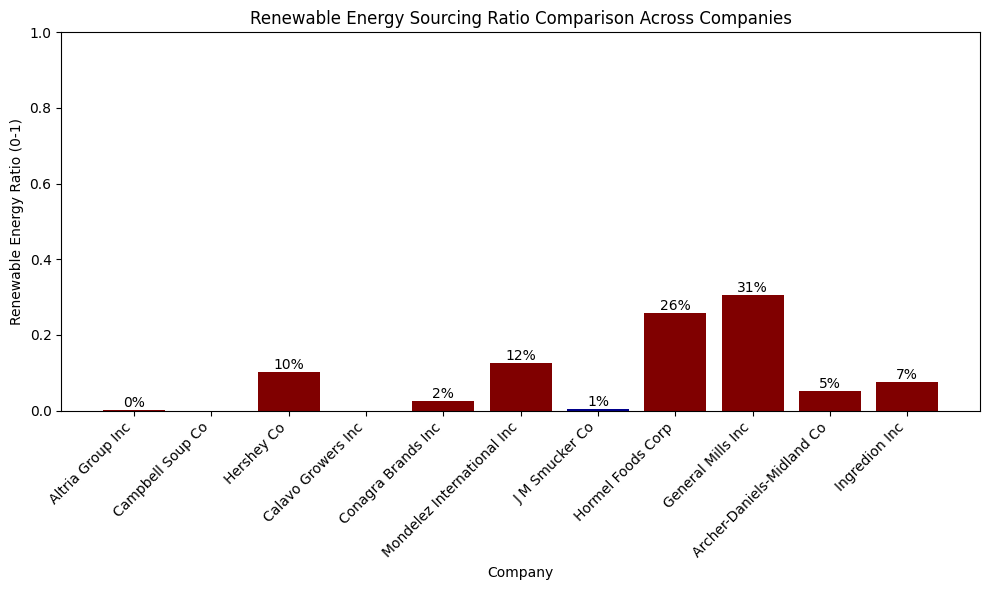

In [16]:
# Data analysis on key ESG Metrics (c) - Proportion of Energy from Responsible Sources
top10_selectedcomp['energy_comp'] = top10_selectedcomp['Renewable Energy Purchased']/top10_selectedcomp['Energy Purchased Direct']

# Plotting
plt.figure(figsize= (10, 6))
for company in top10_selectedcomp['Company Common Name']:
    color = 'maroon'  # Default color for other companies
    if company == target_company:
        color = 'darkblue'  # Target company color

    ratio = top10_selectedcomp[top10_selectedcomp['Company Common Name'] == company]['energy_comp'].values[0]
    plt.bar(company, ratio, color=color)

plt.xlabel("Company")
plt.ylabel("Renewable Energy Ratio (0-1)")
plt.title("Renewable Energy Sourcing Ratio Comparison Across Companies")
plt.xticks(rotation=45, ha= 'right')
plt.ylim(0, 1)
plt.tight_layout()

# Add values on top of bars
for company in top10_selectedcomp['Company Common Name']:
    ratio = top10_selectedcomp[top10_selectedcomp['Company Common Name'] == company]['energy_comp'].values[0]
    percentage = ratio * 100
    plt.text(company, ratio, f"{percentage:.0f}%", ha='center', va='bottom')

plt.show()



In [17]:
# Data analysis on key ESG Metrics (c) -- Company Diversity in Staff and Leadership Index
# building my own index for GSE
diversity_metrics = [
    'Black or African American - Ethnic Minorities Employees Percentage',
    'Hispanic or Latino - Ethnic Minorities Employees Percentage',
    'Other - Ethnic Minorities Employees Percentage',
    'Ethnic Minorities Managers Percentage',
    'Ethnic Minorities Board Percentage'
]

# building an evaluation function for the diversity metrics above
def compare_to_industry(df, target_company, diversity_metrics, top10_selectedcomp=None): #Added the optional top10_selectedcomp argument.
    target_data = df[df['Company Common Name'] == target_company].iloc[0]
    results = {}  # Dictionary to store results for summary print

    for metric in diversity_metrics:
        if metric not in df.columns:
            print(f"Warning: Metric '{metric}' not found in the data. Skipping.")
            continue

        if pd.isna(target_data[metric]):
            print(f"No data available for {target_company} in {metric} to calculate its rank.")
            continue

        industry_data = df[df['Company Common Name'] != target_company][metric]
        industry_percentile_rank = (industry_data < target_data[metric]).sum() / len(industry_data) * 100
        industry_category = categorize_rank(industry_percentile_rank)

        top10_percentile_rank = None
        top10_category = None

        if top10_selectedcomp is not None: #Only do the calculation if it is not none.
            try:
                top10_data = top10_selectedcomp[top10_selectedcomp['Company Common Name'] != target_company][metric]
                top10_percentile_rank = (top10_data < target_data[metric]).sum() / len(top10_data) * 100
                top10_category = categorize_rank(top10_percentile_rank)
            except KeyError:
                print(f"Warning: Metric '{metric}' not found in top 10 data. Skipping peer comparison.")
        else:
            print("top10_selectedcomp is not defined, skipping peer comparison.")

        print(f"\n{metric} Ranking for {target_company}:")
        print(f"Compared to the industry: {industry_category} ({industry_percentile_rank:.1f}th percentile).")
        if top10_percentile_rank is not None:
            print(f"Compared to top 10 peers: {top10_category} ({top10_percentile_rank:.1f}th percentile).")

        results[metric] = {  # Store results for summary
            "industry_category": industry_category,
            "industry_percentile_rank": industry_percentile_rank,
            "top10_category": top10_category,
            "top10_percentile_rank": top10_percentile_rank
        }
    return results

def categorize_rank(percentile_rank):
    if percentile_rank >= 90:
        return "top 10%"
    elif percentile_rank >= 75:
        return "top 25%"
    elif percentile_rank >= 50:
        return "above average"
    elif percentile_rank >= 25:
        return "below average"
    else:
        return "bottom 25%"

# exploring our target company rankings
diversity_results = compare_to_industry(esg_df, target_company, diversity_metrics, top10_selectedcomp) 

print("\n--- Summary ---")
for metric, data in diversity_results.items():
    print(f"{metric}:")
    print(f"  Industry: {data['industry_category']} ({data['industry_percentile_rank']:.1f}th percentile)")
    if data["top10_category"] is not None: 
        print(f"  Top 10 Peers: {data['top10_category']} ({data['top10_percentile_rank']:.1f}th percentile)")


Black or African American - Ethnic Minorities Employees Percentage Ranking for J M Smucker Co:
Compared to the industry: bottom 25% (15.4th percentile).
Compared to top 10 peers: bottom 25% (0.0th percentile).

Hispanic or Latino - Ethnic Minorities Employees Percentage Ranking for J M Smucker Co:
Compared to the industry: bottom 25% (7.3th percentile).
Compared to top 10 peers: bottom 25% (10.0th percentile).

Other - Ethnic Minorities Employees Percentage Ranking for J M Smucker Co:
Compared to the industry: bottom 25% (23.4th percentile).
Compared to top 10 peers: below average (40.0th percentile).
No data available for J M Smucker Co in Ethnic Minorities Managers Percentage to calculate its rank.

Ethnic Minorities Board Percentage Ranking for J M Smucker Co:
Compared to the industry: below average (26.0th percentile).
Compared to top 10 peers: bottom 25% (0.0th percentile).

--- Summary ---
Black or African American - Ethnic Minorities Employees Percentage:
  Industry: bottom 25%

In [18]:
# Data analysis on key ESG Metrics (c) -- Employee Quality Experience Index
# Employee indicators of interest

employee_metrics = [
    'Trade Union Representation',
    'Injuries To Million Hours',
    'Employee Health & Safety Training Hours',
    'Employee Satisfaction',
    'Employee Accidents'
]

# exploring our target company rankings
employee_metrics = compare_to_industry(esg_df, target_company, employee_metrics, top10_selectedcomp) 

print("\n--- Summary ---")
for metric, data in employee_metrics.items():
    print(f"{metric}:")
    print(f"  Industry: {data['industry_category']} ({data['industry_percentile_rank']:.1f}th percentile)")
    if data["top10_category"] is not None: 
        print(f"  Top 10 Peers: {data['top10_category']} ({data['top10_percentile_rank']:.1f}th percentile)")


Trade Union Representation Ranking for J M Smucker Co:
Compared to the industry: below average (43.6th percentile).
Compared to top 10 peers: below average (30.0th percentile).
No data available for J M Smucker Co in Injuries To Million Hours to calculate its rank.
No data available for J M Smucker Co in Employee Health & Safety Training Hours to calculate its rank.
No data available for J M Smucker Co in Employee Satisfaction to calculate its rank.
No data available for J M Smucker Co in Employee Accidents to calculate its rank.

--- Summary ---
Trade Union Representation:
  Industry: below average (43.6th percentile)
  Top 10 Peers: below average (30.0th percentile)


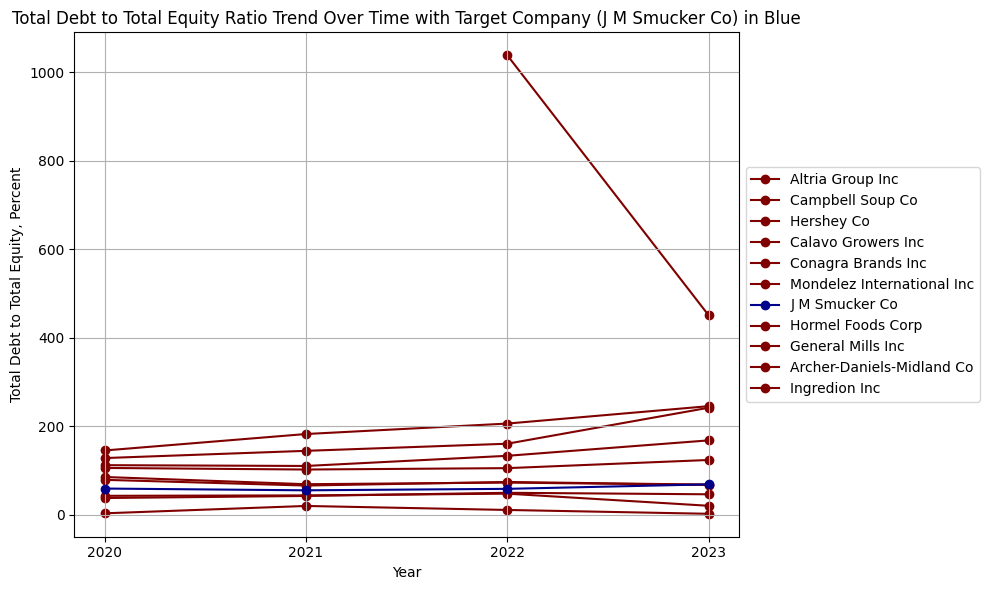

In [19]:
# Data analysis on key ESG Metrics (c) -- Total Debt to Total Equity
# There are several columns with the same name, missing the year labels so here we must add them
year_columns = [col for col in top10_selectedcomp.columns if 'Total Debt to Total Equity, Percent' in col]
year_columns.sort()
years = [2020, 2021, 2022, 2023]

# Plotting
plt.figure(figsize= (10, 6))
for company in top10_selectedcomp['Company Common Name']:
    color = 'maroon'  # Default color for other companies
    if company == target_company:
        color = 'darkblue'
        zorder = 2
    else:
        zorder = 1

    company_data = top10_selectedcomp[top10_selectedcomp['Company Common Name'] == company][year_columns].values.tolist()[0]
    plt.plot(years, company_data, marker='o', color=color, label=company, zorder= zorder)


plt.xlabel("Year")
plt.ylabel("Total Debt to Total Equity, Percent")
plt.title(f"Total Debt to Total Equity Ratio Trend Over Time with Target Company ({target_company}) in Blue")
plt.xticks(years)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.tight_layout()
plt.show()